<a href="https://colab.research.google.com/github/cchen744/olist-regional-customer-experience-analysis/blob/main/01_data_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load datasets

In [35]:
import os
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

os.environ['KAGGLE_USERNAME'] = "chenmengmengchen" # Replace with username from json
os.environ['KAGGLE_KEY'] = "KGAT_f146268b4a26741708c060f77c63a2b3"           # Replace with key from json

from kaggle.api.kaggle_api_extended import KaggleApi

# 1. Authenticate
api = KaggleApi()
api.authenticate()

# 2. Download and Extract
# This handles the "extraction" part automatically with unzip=True
dataset_slug = "olistbr/brazilian-ecommerce"
download_path = "./brazilian_ecommerce_data"

print(f"Downloading {dataset_slug}...")
api.dataset_download_files(dataset_slug, path=download_path, unzip=True)
print("Download and extraction complete.\n")

# 3. Load the data using os.listdir
# The Olist dataset has multiple CSV files (orders, customers, products, etc.)
dataframes = {}

print("Loading files...")
for filename in os.listdir(download_path):
    if filename.endswith(".csv"):
        # Construct full file path
        file_path = os.path.join(download_path, filename)

        # Create a simpler name for the dataframe (e.g., "olist_orders_dataset.csv" -> "orders")
        # This is optional but makes accessing them easier
        df_name = filename.split('_dataset')[0].replace('olist_', '')

        # Load into dictionary
        dataframes[df_name] = pd.read_csv(file_path)
        print(f"--> Loaded {filename} as '{df_name}' (Shape: {dataframes[df_name].shape})")

# Example: Accessing one of the loaded tables
print("\nExample: First 5 rows of orders:")

Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
Download and extraction complete.

Loading files...
--> Loaded olist_orders_dataset.csv as 'orders' (Shape: (99441, 8))
--> Loaded olist_order_items_dataset.csv as 'order_items' (Shape: (112650, 7))
--> Loaded olist_customers_dataset.csv as 'customers' (Shape: (99441, 5))
--> Loaded olist_sellers_dataset.csv as 'sellers' (Shape: (3095, 4))
--> Loaded olist_geolocation_dataset.csv as 'geolocation' (Shape: (1000163, 5))
--> Loaded product_category_name_translation.csv as 'product_category_name_translation.csv' (Shape: (71, 2))
--> Loaded olist_order_reviews_dataset.csv as 'order_reviews' (Shape: (99224, 7))
--> Loaded olist_products_dataset.csv as 'products' (Shape: (32951, 9))
--> Loaded olist_order_payments_dataset.csv as 'order_payments' (Shape: (103886, 5))

Example: First 5 rows of orders:


In [3]:
for df_name, df in dataframes.items():
    print('\n',df_name,'\n', df.columns,'\n',df.shape)


 orders 
 Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object') 
 (99441, 8)

 order_items 
 Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object') 
 (112650, 7)

 customers 
 Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object') 
 (99441, 5)

 sellers 
 Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object') 
 (3095, 4)

 geolocation 
 Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object') 
 (1000163, 5)

 product_category_name_translation.csv 
 Index(['product_category_name', 'product_category_name_english'], dt

Join dataframes to link reviews to their geolocation.

In [4]:
order_reviews_df = dataframes['order_reviews']
orders_df = dataframes['orders']
customers_df = dataframes['customers']
geolocation_df = dataframes['geolocation'][['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state']]

In [5]:
# join reviews to order
print(order_reviews_df.shape[0])
print(order_reviews_df['order_id'].nunique())
review_with_orders = pd.merge(order_reviews_df, orders_df, on='order_id')
print(review_with_orders.shape[0])


99224
98673
99224


In [6]:
# join orders with customers
print(orders_df.shape[0])
print(customers_df['customer_id'].nunique())
orders_with_customers = pd.merge(review_with_orders, customers_df, on='customer_id')

99441
99441


In [7]:
# final step: join geo location
print(orders_with_customers.shape[0])
print(orders_with_customers['customer_zip_code_prefix'].nunique())
final_df = pd.merge(orders_with_customers, geolocation_df, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

99224
14973


In [8]:
review_with_orders["review_score"].max()

5

In [9]:
final_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_city,geolocation_state
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,6030,osasco,SP
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,6030,osasco,SP
2,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,6030,osasco,SP
3,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,6030,osasco,SP
4,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,6030,osasco,SP


In [10]:
final_df.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'],
      dtype='object')

Find:

(1) the proportion of negative reviews (defined as review score ≤ 2 among reviewed orders) per state;

(2) average delivery time per state, computed for all delivered orders as well as for orders with negative reviews; and

(3) seller presence metrics, measured as the number of unique sellers per state.

In [80]:
final_df['negative_flag']= final_df['review_score']<=2
final_df['delivery_time'] = (pd.to_datetime(final_df['order_delivered_customer_date']) - pd.to_datetime(final_df['order_purchase_timestamp'])).dt.total_seconds() / (24 * 3600)
review_state_df = final_df.groupby('geolocation_state')[['negative_flag','review_score','delivery_time']].mean().rename(columns={'negative_flag':'negative_review_proportion',
                                                                                                                                  'delivery_time': 'average_delivery_days',
                                                                                                                                  'review_score':"average_review_score"})

In [81]:
review_state_df

,negative_review_proportion,average_review_score,average_delivery_days
geolocation_state,,,
AC,0.148543,4.033949,20.883330
AL,0.244396,3.728064,23.647624
AM,0.178482,4.092195,24.968192
AP,0.076449,4.183107,28.437964
BA,0.196821,3.848503,18.637270
CE,0.191150,3.865141,21.487200
DF,0.142718,4.082291,12.977091
ES,0.152765,4.050175,15.258505
GO,0.153318,4.012771,15.673265


In [89]:
sellers = dataframes['sellers']
print(sellers.head())
print(geolocation_df.head())

                          seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP  
   geolocation_zip_code_prefix geolocation_city geolocation_state
0                         1037        sao paulo                SP
1                         1046        sao paulo                SP
2                         1046        sao paulo                SP
3                         1041        sao paulo                SP
4                         1035        sao paulo                SP


In [93]:
sellers_state_df = sellers.groupby('seller_state')['seller_id'].count()
sellers_state_df

,seller_id
seller_state,
AC,1
AM,1
BA,19
CE,13
DF,30
ES,23
GO,40
MA,1
MG,244


Visualization

In [41]:
geojson_url = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/brazil-states.geojson"
gdf = geopandas.read_file(geojson_url)

In [84]:
review_gdf = gdf.merge(review_state_df, left_on='sigla', right_on='geolocation_state')
review_gdf.head()

,id,name,sigla,regiao_id,codigo_ibg,cartodb_id,created_at,updated_at,geometry,negative_review_proportion,average_review_score,average_delivery_days
0,1,Acre,AC,3,12,1,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-73.60818 -7.20194, -72.86963 ...",0.148543,4.033949,20.883330
1,2,Alagoas,AL,4,27,2,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-35.46516 -8.82549, -35.46626 ...",0.244396,3.728064,23.647624
2,3,Amazonas,AM,3,13,3,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-67.32553 2.03012, -67.32234 2...",0.178482,4.092195,24.968192
3,4,Amapá,AP,3,16,4,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-51.18168 4.00889, -51.179 3.9...",0.076449,4.183107,28.437964
4,5,Bahia,BA,4,29,5,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-39.2882 -8.5629, -39.28229 -8...",0.196821,3.848503,18.637270


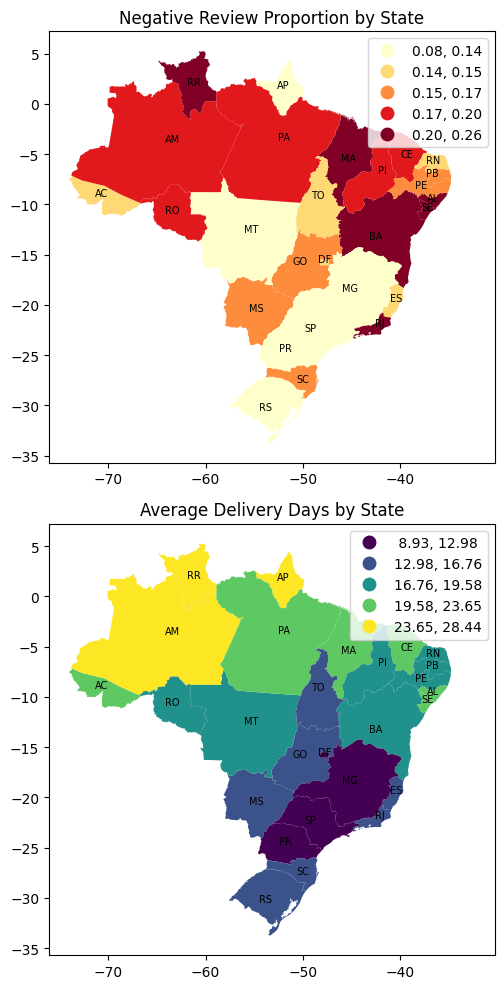

In [104]:
fig, ax = plt.subplots(2, figsize=(10, 10))

review_gdf.plot(column='negative_review_proportion', cmap='YlOrRd', scheme="Quantiles",k=5,legend=True,ax=ax[0])
ax[0].set_title('Negative Review Proportion by State')

review_gdf.plot(column='average_delivery_days', scheme="NaturalBreaks",k=5,legend=True,ax=ax[1])
ax[1].set_title('Average Delivery Days by State')

review_gdf["label_point"] = review_gdf.geometry.representative_point()
for i in [0,1]:
  for _, row in review_gdf.iterrows():
      ax[i].text(
          row["label_point"].x,
          row["label_point"].y,
          row["sigla"],
          fontsize=7,
          ha="center"
      )

plt.tight_layout()
plt.show()

<Axes: >

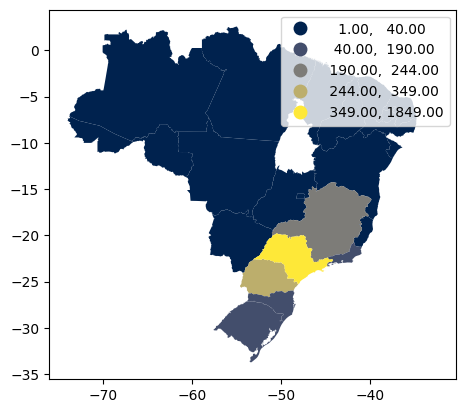

In [102]:
sellers_state_gdf=gdf.merge(sellers_state_df,left_on='sigla', right_on='seller_state')
sellers_state_gdf.plot(column='seller_id',legend=True,cmap='cividis',scheme="NaturalBreaks",k=5)